In [28]:
%matplotlib inline

import sys
import os
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
from collections import Counter

matplotlib.rcParams['figure.dpi'] = 140

In [29]:
# digital.csv is the export from Saleae Logic2.
# The format is time-of-transition, value.
#
time, _bit = np.genfromtxt(os.path.join(os.getenv("HOME"),"Downloads/digital.csv"), skip_header=1, delimiter=",", unpack=True, )
bit = _bit.astype(np.int8)

# Most frames are separate by ~80 microseconds.
sel, = np.where((time[1:] - time[:-1]) > 80*1e-6)
sel += 1

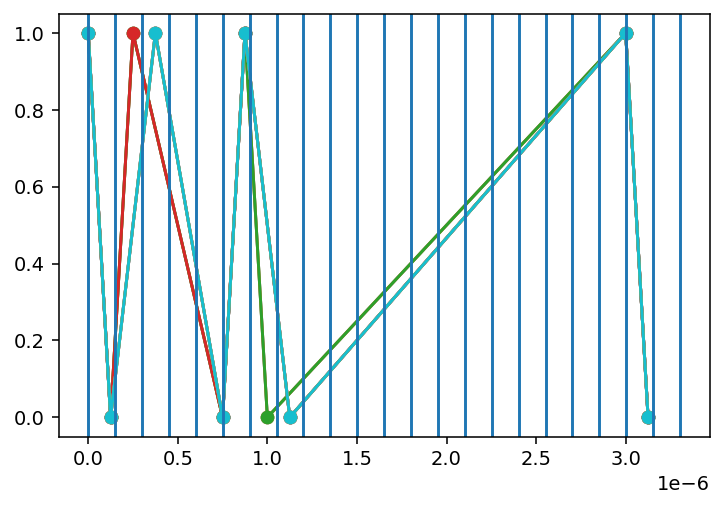

In [30]:
n_frames = 10

for start, end in zip(sel[:n_frames], sel[1:(1+n_frames)]):
    plt.plot(time[start:end] - time[start], bit[start:end], '-o')
    
freq = 3.33e6*2
for n in range(23):
    plt.axvline(n*(1/freq))
    


In [31]:
start = sel[1]
end = sel[2]
sample_t = 1/freq * np.arange(23)
delta_t = time[start:end] - time[start]
idx = np.searchsorted(delta_t, sample_t, side='right') - 1
idx

array([0, 1, 2, 2, 2, 3, 4, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 6, 7,
       7])

In [32]:
bits = bit[start:end]
bits

array([1, 0, 1, 0, 1, 0, 1, 0], dtype=int8)

In [33]:
data_bits = bits[idx]

In [34]:
data_bits

array([1, 0, 1, 1, 1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0,
       0], dtype=int8)

 Wire format:
``` 
[1, 0, 1,   - Header
 1, 1, 0, 1,   0, 0, 0, 0,   - Low byte, little endian
 0,  - Parity
 0, 0, 0, 0,   0, 0, 0, 0,  - High Byte, little endian
 1,  - Parity
 0,
 0]
```

In [43]:
freq = 3.3e6*2

all_strings_out = []
parity_err1 = 0
parity_err2 = 0
parity_err_strings = []
good_strings_out = []
all_strings_timings = []
for start, end in zip(sel[:-1], sel[1:]):
    delta_t = time[start:end] - time[start]
    bits = bit[start:end]
    sample_t = 1/freq * np.arange(23)
    idx = np.searchsorted(delta_t, sample_t, side='right') - 1
    data_bits = bits[idx]


    str_out = "{:02x}{:02x}".format(np.packbits(data_bits[12:20], bitorder="little")[0], np.packbits(data_bits[3:11], bitorder="little")[0])
    all_strings_out.append(str_out)
    all_strings_timings.append(time[start])
    if(str_out == "1f0d"):
        print("start: ", start)
        print("end: ", end)
        print(data_bits)
    
    err1 = False
    err2 = False
    if((np.sum(data_bits[12:20]) + data_bits[20]) % 2 == 0):
        err1 = True

        
    if((np.sum(data_bits[3:11]) + data_bits[11]) % 2 == 0):
        err2 = True
        
    if(err1):
        parity_err1 += 1        
    if(err2):
        parity_err2 += 1
        
    if(err1 or err2):
        parity_err_strings.append(str_out)
    else:
        good_strings_out.append(str_out)
        
    
    
print("Parity errors ", parity_err1, parity_err2)
print(Counter(good_strings_out))

reset_idx = all_strings_out.index("0e8d")
print(all_strings_out[reset_idx:(reset_idx+20)])

# 0e8d - tape initialize
# 0f0d - Read command

start:  19817
end:  19825
[1 0 1 1 0 1 1 0 0 0 0 0 1 1 1 1 1 0 0 0 0 0 0]
Parity errors  1741 10988
Counter({'000b': 25338, '0013': 7923, '0e8d': 1, '1f0d': 1})
['0e8d', '000f', '1f0d', '000b', '000b', '000b', '000b', '000b', '000b', '000b', '000b', '000b', '000b', '000b', '000b', '000b', '000b', '000b', '000b', '000b']


```
1 0 1 
1 0 1 1   0 0 0 0
0
1 1 1 1   1 0 0 0 
0 0 0
```

In [36]:
Counter(parity_err_strings)

Counter({'001b': 2222, '0013': 176, '0017': 212, '000f': 1})

In [37]:
# Byte order
#0b 0001 1111 0000 1111 - bad 0x1f0f
#0b 0000 1111 0000 1101 - Good 0x0f0d

# wire order:
# 101 1011 0000 1111 0000  - Good
#      *             *

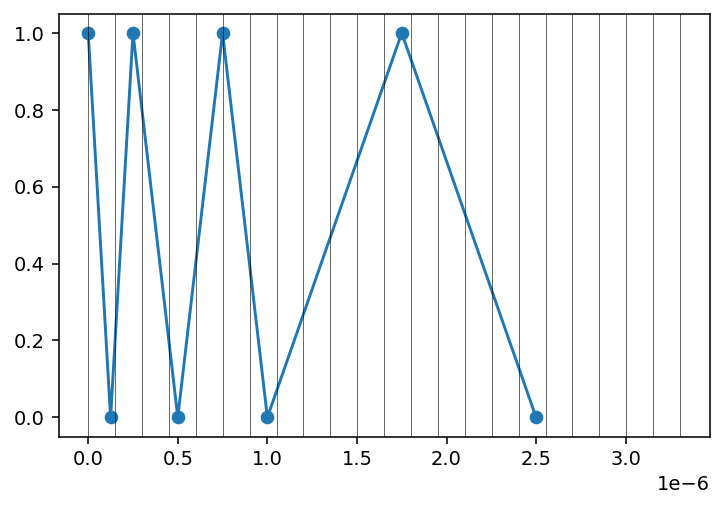

In [40]:
start = 19817
end = 19825
plt.plot(time[start:end] - time[start], bit[start:end], '-o')

freq = 3.33e6*2
for n in range(23):
    plt.axvline(n*(1/freq), lw=0.3, color='k')

In [44]:
print(all_strings_timings[reset_idx:(reset_idx+20)])

[0.8528095, 0.852898875, 1.48333225, 1.483421375, 1.48351125, 1.483601125, 1.483691, 1.483780875, 1.48387075, 1.483960625, 1.4840505, 1.484140375, 1.48423025, 1.484320125, 1.48441, 1.484499875, 1.48458975, 1.484679625, 1.4847695, 1.484859375]


In [41]:
all_strings_out[reset_idx:(reset_idx+30)]

['0e8d',
 '000f',
 '1f0d',
 '000b',
 '000b',
 '000b',
 '000b',
 '000b',
 '000b',
 '000b',
 '000b',
 '000b',
 '000b',
 '000b',
 '000b',
 '000b',
 '000b',
 '000b',
 '000b',
 '000b',
 '000b',
 '000b',
 '000b',
 '000b',
 '000b',
 '000b',
 '001b',
 '001b',
 '001b',
 '001b']